# Hillfort detection with LiDAR data
## Data management

## Table of contents

[Code](#code)

1. [**Initializing and training the model**](#initializing-and-training-the-model)
2. [**Evaluating the model**](#evaluating-the-model)
3. [**Hyperparameter tuning**](#hyperparameter-tuning)
4. [**Results**](#results)

[End](#end)

## Code

### Defined functions

In [6]:
# Imports
import os
import re
import csv
import typing
import itertools
import json
import logging
import warnings
import evaluate
import types
import pandas as pd
import sklearn as sk
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import laspy # Reading LAS file format

In [2]:
class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [3]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
test_las = laspy.read('../data/classified_lazFiles/397689_2023_tava.laz')

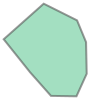

(0.0, 0.0, 0.0) (1.0, 1.0, 1.0)
POLYGON ((0.2154821638250724 0.5331751415506005, 0.3161431704647839 0.4828446377068758, 0.343413443188183 0.4168739784508944, 0.345303462119773 0.3216530261561274, 0.3144031530246139 0.2535523446276784, 0.2374723837710917 0.2548123579472303, 0.174411753192544 0.3260730700567365, 0.0947009560186416 0.4258040674030781, 0.2154821638250724 0.5331751415506005))


In [ ]:
test_poly = normalized_polygons['polygons'][0][0]
display(test_poly)
print((test_las.header.x_min, test_las.header.y_min, test_las.header.z_min), (test_las.header.x_max, test_las.header.y_max, test_las.header.z_max))
print(test_poly)

In [ ]:
xyz = test_las.xyz
xyzc = np.hstack((xyz, test_las.points.array['classification'].reshape(-1, 1)))
X = xyz
y = xyz[:, -1] == 12
y = y.reshape(-1, 1)

print(X.shape, y.shape)

(4715859, 3) (4715859, 1)


In [ ]:
def ToTensor(pointcloud):
    assert len(pointcloud.shape)==2
    return torch.from_numpy(pointcloud)

In [ ]:
ToTensor(X)

tensor([[0.1000, 0.0000, 0.2500],
        [0.1000, 0.0000, 0.2100],
        [0.1000, 0.0000, 0.1700],
        ...,
        [0.7000, 0.8000, 0.1600],
        [0.7000, 0.8000, 0.1600],
        [0.7000, 0.8000, 0.3100]], dtype=torch.float64)

### Initializing and training the model

### Evaluating the model

### Hyperparameter tuning

### Results

## End